![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

[Dataset](https://www.kaggle.com/mkechinov/ecommerce-purchase-history-from-electronics-store)

This file contains purchase data from April 2020 to November 2020 from a large home appliances and electronics online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.


In [1]:
%reload_kedro

2021-09-18 00:38:01,910 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-09-18 00:38:01,953 - root - INFO - ** Kedro project productrec
2021-09-18 00:38:01,955 - root - INFO - Defined global variable `context`, `session` and `catalog`


# Global Imports

In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

# Data Exploration

In [4]:
df = catalog.load("electronics_kaggle_data")

df.head()


2021-09-18 00:38:44,853 - kedro.io.data_catalog - INFO - Loading data from `electronics_kaggle_data` (CSVDataSet)...


,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


## Checking for missing values

It looks like the order and product id are always available. That is all that we will be using from this dataset, to the rest is fine.

In [5]:
df.isna().sum()

event_time             0
order_id               0
product_id             0
category_id       431954
category_code     612202
brand             506005
price             431954
user_id          2069352
dtype: int64

Let's look at the number of products and see how they are distributed among the orders. We can use the value_counts method from pandas to get an idea of how often each product is ordered.

There are 25113 unique products

Here are the counts of products ordered from largest to smallest
[44491 41076 38786 ...     1     1     1]

And a graph of what the curve looks like:


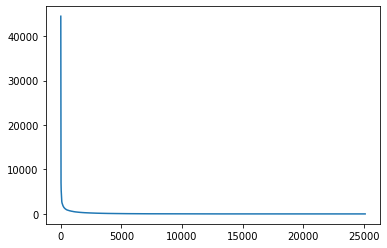

In [6]:
product_counts = df['product_id'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('Here are the counts of products ordered from largest to smallest')
print(product_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()

Wow! It looks like there are a few products that are purchased a lot. Let's take a look at those to see what they are.

In [7]:
df['product_id'].value_counts().head()

1515966223523303302    44491
1515966223523303301    41076
1515966223523303308    38786
1515966223523303310    38472
1515966223523303314    36530
Name: product_id, dtype: int64

In [8]:
print(len(df['order_id'].unique()))
print(len(df))
# from collections import Counter
# Counter(df['product_id'].value_counts().to_numpy())[3]

1435266
2633521


This is a very extreme curve. It's unlikely that we will be able to use any products that don't appear in multiple orders. We can do a few more things to see how much usable data we have.

First, we will tell value_counts to use percentages of the total instead of the sum values and divide the results equally into 10 bins.

In [9]:
df['product_id'].value_counts(normalize=True, bins=10)

(1.5150937552801208e+18, 1.6032130464058678e+18]    0.793554
(2.2139408066833234e+18, 2.3011876295801027e+18]    0.187847
(2.3011876295801027e+18, 2.388434452476882e+18]     0.018599
(1.6032130464058678e+18, 1.6904598693026473e+18]    0.000000
(1.6904598693026473e+18, 1.7777066921994266e+18]    0.000000
(1.7777066921994266e+18, 1.8649535150962058e+18]    0.000000
(1.8649535150962058e+18, 1.952200337992985e+18]     0.000000
(1.952200337992985e+18, 2.0394471608897644e+18]     0.000000
(2.0394471608897644e+18, 2.1266939837865439e+18]    0.000000
(2.1266939837865439e+18, 2.2139408066833234e+18]    0.000000
Name: product_id, dtype: float64

<AxesSubplot:>

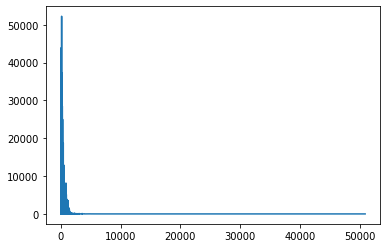

In [10]:
df['price'].value_counts().sort_index().plot()

<AxesSubplot:xlabel='order_id'>

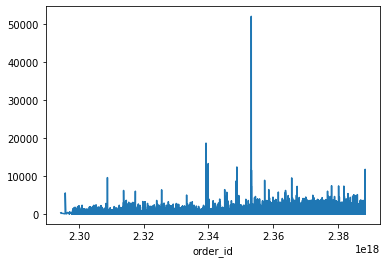

In [11]:
totals = df.groupby(df.order_id)['price'].sum()
 
totals.plot()

In [12]:
df['category_code'].value_counts()

electronics.smartphone              357682
appliances.kitchen.refrigerators     77386
16.18                                72969
electronics.video.tv                 71711
computers.notebook                   71436
                                     ...  
31.25                                    1
106.43                                   1
92.34                                    1
31.94                                    1
347.20                                   1
Name: category_code, Length: 510, dtype: int64

In [13]:
df['brand'].value_counts()

samsung                358928
ava                    118161
tefal                   78653
apple                   74709
huawei                  57438
                        ...  
1515915625512084507         1
1515915625512084417         1
1515915625512083939         1
1515915625512084524         1
zevs                        1
Name: brand, Length: 23021, dtype: int64

Another thing we can do is compute the sparsity of the data. This is useful to see if there is enough overlap between the orders and products to make a useful decision for recommendations.

In [14]:
order_counts = df['order_id'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

number of orders: 1435266, number of items: 25113
matrix sparsity: 0.999927


Compare that with the 100k movielens dataset that has:

```
number of users: 943, number of items: 1682
matrix sparsity: 0.936953
```

In addition to reducing the sparsity, another issue with this dataset is the greater number of items and orders. When I tried to re-use a notebook built for the 100k movielens dataset on this ecomerce data, it immediately ran out of memory when attempting to use the KNNBasic algorithm.

In [15]:
product = 943 * 1682
print('Size for movielens: 'f'{product:,}')
 
product = 1435266 * 25113
print('Size for ecommerce dataset: 'f'{product:,}')

Size for movielens: 1,586,126
Size for ecommerce dataset: 36,043,835,058


This is a pretty clear reason why the in-memory recommendation approaches that work with movielens run out of memory when trying to apply them to the ecommerce dataset.

We need to look at reducing the dataset into something both useful and manageable. To start with, we can remove any products that don't appear more than some value.

In [31]:
#@title Example form fields
#@markdown Forms support many types of fields.
 
filter_value = 100  #@param {type: "number"}
#@markdown

In [32]:
product_group = df.loc[:, ['order_id', 'product_id']].groupby('product_id').count()
 
multi_product = product_group[product_group.order_id >= filter_value].count()
single_product = product_group[product_group.order_id < filter_value].count()
 
print('Products in at least',filter_value,'orders:',multi_product['order_id'])
print('Products in less than',filter_value,'orders:',single_product['order_id'])
 
# We can capture the list of mutiple product orders with this:
product_filter = product_group[product_group.order_id >= filter_value].index.tolist()
 
product_filtered_df = df[df['product_id'].isin(product_filter)].copy()

Products in at least 100 orders: 4112
Products in less than 100 orders: 21001


We can also remove orders that don't have more than some number of items.



In [37]:
#@title Example form fields
#@markdown Forms support many types of fields.
 
minimum_order_size =   5#@param {type: "number"}
maximum_order_size =   20#@param {type: "number"}
 
#@markdown

In [38]:
order_group = product_filtered_df.loc[:, ['order_id', 'product_id']].groupby('order_id').count()
 
multi_order = order_group[(order_group.product_id >= minimum_order_size) & (order_group.product_id <= maximum_order_size)].count()
single_order = order_group[(order_group.product_id < minimum_order_size) | (order_group.product_id > maximum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['product_id'])
print('Orders with less than',minimum_order_size,'products:',single_order['product_id'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.product_id >= minimum_order_size) & (order_group.product_id <= maximum_order_size)].index.tolist()

Orders with at least 5 products: 68665
Orders with less than 5 products: 1237072


In [39]:
filtered_df = product_filtered_df[product_filtered_df['order_id'].isin(order_filter)].copy()
print('Original dataframe length:', len(df))
print('Filtered dataframe length:', len(filtered_df))

Original dataframe length: 2633521
Filtered dataframe length: 450396


There are 4092 unique products


And a graph of what the curve looks like:


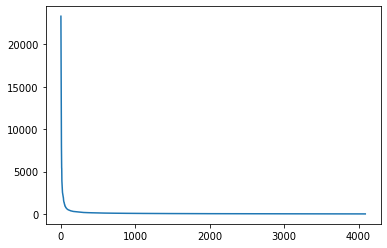

number of orders: 68665, number of items: 4092
matrix sparsity: 0.990627


In [40]:
product_counts = filtered_df['product_id'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()
 
order_counts = filtered_df['order_id'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

In [48]:
filtered_df['product_id'] = filtered_df['product_id'].astype(str)
filtered_df['quantity'] = 1
filtered_df['description'] = filtered_df['brand'] + filtered_df['category_code']

item_lookup = filtered_df[['product_id', 'description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['product_id'] = item_lookup.product_id.astype(str) # Encode as strings for future lookup ease


In [49]:
catalog.save("electronics_transactions", filtered_df)
catalog.save("electronics_products", item_lookup)

2021-09-18 00:56:10,410 - kedro.io.data_catalog - INFO - Saving data to `electronics_transactions` (CSVDataSet)...
2021-09-18 00:56:13,237 - kedro.io.data_catalog - INFO - Saving data to `electronics_products` (CSVDataSet)...
